In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trade-data/GainsAndLosses.csv


In [2]:
file_path = '/kaggle/input/trade-data/GainsAndLosses.csv'
df_raw = pd.read_csv(file_path, header=None)
header_row_index = df_raw[df_raw.iloc[:, 0] == 'Symbol'].index[0]
df = pd.read_csv(file_path, header=header_row_index)

# Preview the data
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Symbol           1027 non-null   object 
 1   Quantity         1027 non-null   float64
 2   Date             1027 non-null   object 
 3   Cost/Share $     1027 non-null   object 
 4   Total Cost $     1027 non-null   float64
 5   Date.1           1027 non-null   object 
 6   Price/Share $    1027 non-null   object 
 7   Proceeds $       1027 non-null   float64
 8   Gain $           1027 non-null   float64
 9   Deferred Loss $  1027 non-null   object 
 10  Term             1027 non-null   object 
 11  Lot Selection    1027 non-null   object 
dtypes: float64(4), object(8)
memory usage: 96.4+ KB


Symbol             0
Quantity           0
Date               0
Cost/Share $       0
Total Cost $       0
Date.1             0
Price/Share $      0
Proceeds $         0
Gain $             0
Deferred Loss $    0
Term               0
Lot Selection      0
dtype: int64

In [3]:
# Data wrangling

# Clean the Symbol column 
df['Symbol'] = df['Symbol'].astype(str).str.strip()

# Define known transaction words (not tickers)
transactions = {'sell', 'buy', 'buy to close', 'sell to close', 'options assignment', 'options expiration'}

# Identify rows that are actual tickers (not transactions)
df['Is_Symbol_Row'] = df['Symbol'].str.lower().apply(lambda x: x not in transactions and x != '')

# Only keep those entries in a new column
df['Symbol_Clean'] = df['Symbol'].where(df['Is_Symbol_Row'])

# Forward-fill ticker symbol
df['Symbol_Filled'] = df['Symbol_Clean'].ffill().infer_objects(copy=False)

# Remove Headers
df['Symbol_Lower_Case'] = df['Symbol'].str.lower().str.strip()

df_cleaned = df[
    (df['Symbol_Lower_Case'].isin(transactions)) |
    (df['Symbol'] != df['Symbol_Filled'])
].copy()
    
# Drop helper columns
df_cleaned.drop(columns=['Is_Symbol_Row', 'Symbol_Clean', 'Symbol_Lower_Case'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

# Preview result
df_cleaned.head()

,Symbol,Quantity,Date,Cost/Share $,Total Cost $,Date.1,Price/Share $,Proceeds $,Gain $,Deferred Loss $,Term,Lot Selection,Symbol_Filled
0,Sell,1900.0,6/6/2025,11.79,22395.49,6/10/2025,11.78,22381.8803,-13.61,0,Short,FIFO,AAL
1,Sell,100.0,6/6/2025,11.79,1178.99,6/10/2025,11.78,1177.9900,-1.00,0,Short,FIFO,AAL
2,Sell,500.0,4/9/2025,12.57,6287.45,4/9/2025,13.19,6597.2300,309.78,0,Short,FIFO,AAOI
3,Sell,200.0,6/6/2025,16.9,3381.00,6/27/2025,27.74,5547.9700,2166.97,0,Short,FIFO,AAOI
4,Sell,500.0,6/12/2025,17.58,8789.05,7/3/2025,29.66,14829.9200,6040.87,0,Short,FIFO,AAOI


In [4]:
df_cleaned['Gain $'] = df_cleaned['Gain $'].astype(str).str.strip()
df_cleaned['Gain $'] = pd.to_numeric(df_cleaned['Gain $'], errors='coerce')
df_cleaned['Gain_Direction'] = df_cleaned['Gain $'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Zero'))


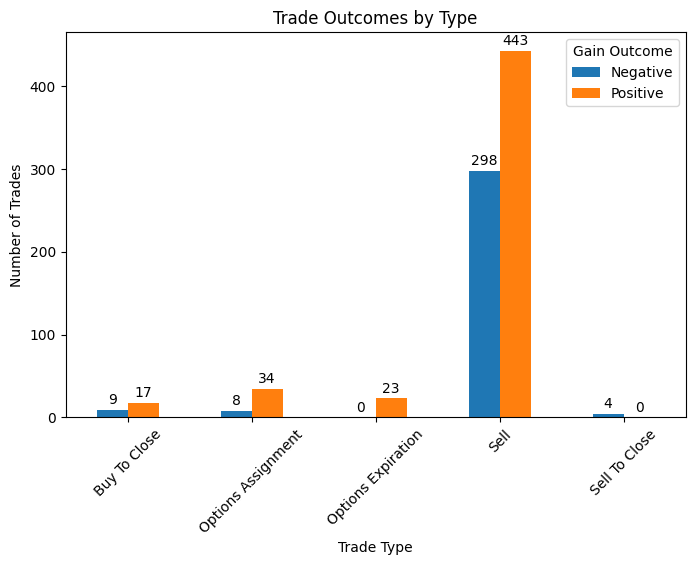

In [5]:
import matplotlib.pyplot as plt

counts = df_cleaned.groupby(['Symbol', 'Gain_Direction']).size().unstack(fill_value=0)

# Bar Chart of type of trade
ax = counts.plot(kind='bar', stacked=False, figsize=(8, 5))

# Title and formatting
plt.title('Trade Outcomes by Type')
plt.xlabel('Trade Type')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.legend(title='Gain Outcome')

# Added counts for clarity
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=10)
    
plt.show()

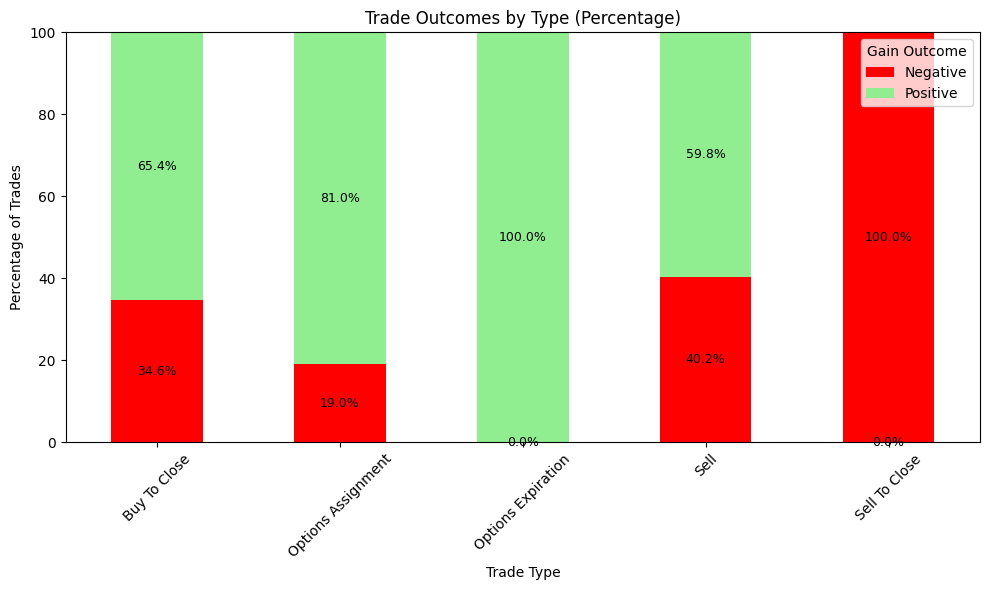

In [6]:
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(10, 6))

custom_colors = {
    'Positive': 'lightgreen',
    'Negative': 'red',
    'Zero': 'gray'
}

percentages.plot(kind='bar', stacked=True, ax=ax, color=[custom_colors[col] for col in percentages.columns])


# Chart Format
ax.set_title('Trade Outcomes by Type (Percentage)')
ax.set_ylabel('Percentage of Trades')
ax.set_xlabel('Trade Type')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend(title='Gain Outcome')
plt.tight_layout()

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

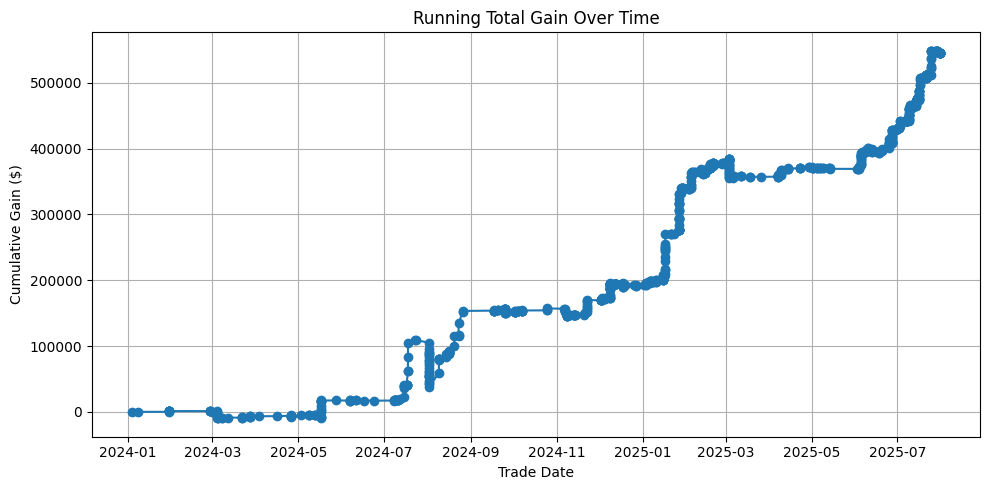

In [7]:
# Convert Date.1 (Which is date trade was completed) to datetime
df_cleaned['Trade_Date'] = pd.to_datetime(df_cleaned['Date.1'], errors='coerce')

# Drop rows with missing dates or gains
df_returns = df_cleaned.dropna(subset=['Trade_Date', 'Gain $']).copy()

# Sort by date
df_returns = df_returns.sort_values('Trade_Date')

# Create a running total of gains
df_returns['Running_Gain'] = df_returns['Gain $'].cumsum()

# Step 6: Plot it
plt.figure(figsize=(10, 5))
plt.plot(df_returns['Trade_Date'], df_returns['Running_Gain'], marker='o', linestyle='-')
plt.title('Running Total Gain Over Time')
plt.xlabel('Trade Date')
plt.ylabel('Cumulative Gain ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Calculating Sharpe, a universal metric of trading
df_cleaned['Return'] = df_cleaned['Gain $'] / df_cleaned['Total Cost $'] # this is return in %
returns = df_cleaned['Return'].replace([np.inf, -np.inf], np.nan).dropna()

# Risk-free rate (optional: assume 2% annualized → ~0.00008 per trade, or set to 0 for short-term)
risk_free_rate = 0.0  # Could use 0.02 / 252 if working with daily data, but this isn't so we will stick with 0.0

# Excess returns
excess_returns = returns - risk_free_rate

# Sharpe Ratio
sharpe_ratio = excess_returns.mean() / excess_returns.std()

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
# Doing it per-trade, and trades are not evenly spaced, so can use unannualized

num_years = 3 # 

avg_trades_per_year = len(df_cleaned) / num_years  # estimate
annualized_sharpe = sharpe_ratio * np.sqrt(avg_trades_per_year)

print(f"Annualized Sharpe Ratio: {annualized_sharpe:.4f}")
# Trading daily, so annualized may be better measure


Sharpe Ratio: 0.0694
Annualized Sharpe Ratio: 1.1586


In [9]:
# The Sharpe Ratio (per trade) of 0.0694 is terrible. This tells us that each trade, on average, returns just ~0.07 units of return per unit of risk.
# But, this doesn't take into account how often the trader trades. The Annualized Sharpe Ratio of 1.16 takes into account the average amount of trades,
# and is a strong number. It suggests that when compounded across all your trades per year, the overall risk-adjusted return is quite solid. This is 
# assumig you consistently trade at the current frequency 

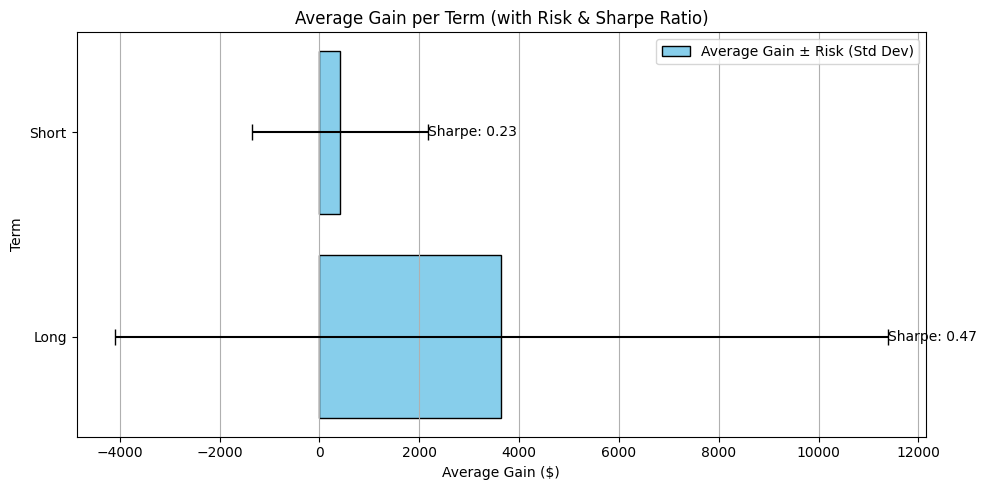

Number of Short-Term Trades: 774
Number of Long-Term Trades: 62


In [10]:
# Plotting average Gain and Risk
# The mean and standard deviation indicate risk/volatility
term_stats = df_cleaned.groupby('Term')['Gain $'].agg(['mean', 'std'])
term_stats['Sharpe'] = term_stats['mean'] / term_stats['std']
term_stats_sorted = term_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(term_stats_sorted.index, term_stats_sorted['mean'], xerr=term_stats_sorted['std'], color='skyblue', edgecolor='black', capsize=6, label='Average Gain ± Risk (Std Dev)')

for i, (term, row) in enumerate(term_stats_sorted.iterrows()):
    plt.text(row['mean'] + row['std'] + 5, i, f"Sharpe: {row['Sharpe']:.2f}", va='center')

plt.title('Average Gain per Term (with Risk & Sharpe Ratio)')
plt.xlabel('Average Gain ($)')
plt.ylabel('Term')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.show()

short_term_count = 0
long_term_count = 0

for term in df_cleaned['Term']:
    if term == 'Short':
        short_term_count += 1
    elif term == 'Long':
        long_term_count += 1

print(f"Number of Short-Term Trades: {short_term_count}")
print(f"Number of Long-Term Trades: {long_term_count}")

In [11]:
# These cells show that the trade does much better with long term trades than short term trades, dispite doing many more short term than long. 
# The short term Sharpe Ratio of 0.23 indicates that for every 1 unit of risk taken, say the trader risks a dollar, they generate 0.23 units of excess
# return, or 0.23 dollars. 

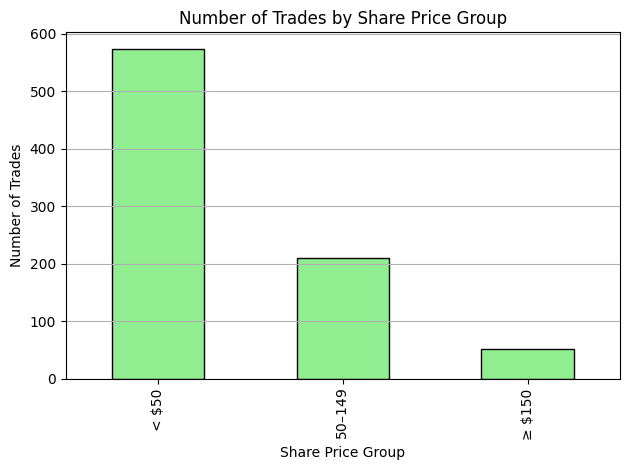

In [12]:
# Same but for Price/Share $
df_cleaned['Price/Share $'] = pd.to_numeric(df_cleaned['Price/Share $'], errors='coerce')
bins = [0,50,150,float('inf')]
labels = ['< $50', '$50–$149', '≥ $150']
df_cleaned['Price_Group'] = pd.cut(df_cleaned['Price/Share $'], bins=bins, labels=labels)
price_group_counts = df_cleaned['Price_Group'].value_counts().sort_index()

price_group_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Number of Trades by Share Price Group')
plt.xlabel('Share Price Group')
plt.ylabel('Number of Trades')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

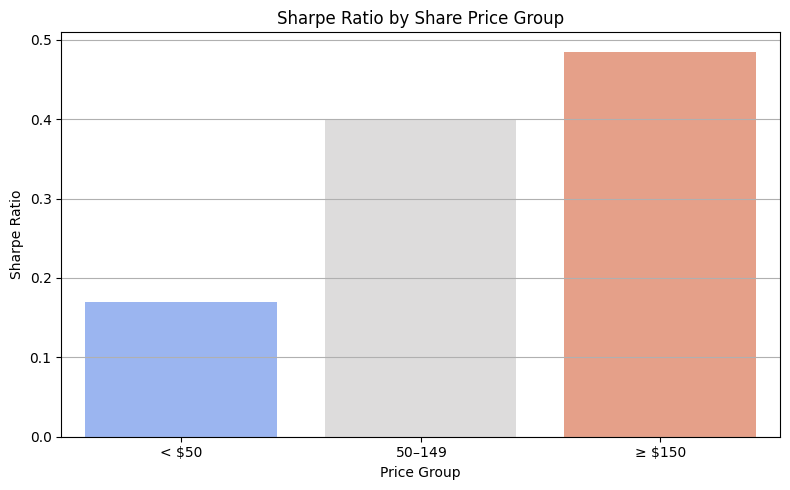

In [13]:
import seaborn as sns
# Drop rows with missing Gain $ or Price Group
df_price_group = df_cleaned.dropna(subset=['Gain $', 'Price_Group'])

# Group by Price Group and calculate average gain and Sharpe ratio
grouped = df_price_group.groupby('Price_Group', observed=True)

# Calculate metrics
gain_mean = grouped['Gain $'].mean()
gain_std = grouped['Gain $'].std()
sharpe_ratio = gain_mean / gain_std

# Combine results into a single DataFrame
price_group_summary = pd.DataFrame({
    'Average Gain ($)': gain_mean,
    'Gain Std Dev ($)': gain_std,
    'Sharpe Ratio': sharpe_ratio
})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=price_group_summary.index, y=price_group_summary['Sharpe Ratio'], palette='coolwarm')
plt.title('Sharpe Ratio by Share Price Group')
plt.xlabel('Price Group')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [14]:
# Sorting price and term
results = []

for price_group in labels:
    for term in df_cleaned['Term'].dropna().unique():
        subset = df_cleaned[(df_cleaned['Price_Group'] == price_group) & (df_cleaned['Term'] == term)]

        if not subset.empty:
            avg_gain = subset['Gain $'].mean()
            std_gain = subset['Gain $'].std()
            sharpe = avg_gain / std_gain if std_gain else float('nan')

            results.append({
                'Price Group': price_group,
                'Term': term,
                'Count': len(subset),
                'Average Gain': avg_gain,
                'Sharpe Ratio': sharpe
            })
summary_df = pd.DataFrame(results)
summary_df.head(10)


,Price Group,Term,Count,Average Gain,Sharpe Ratio
0,< $50,Short,538,309.860743,0.181429
1,< $50,Long,36,3517.025278,0.364073
2,$50–$149,Short,192,630.566771,0.347476
3,$50–$149,Long,18,2669.181111,0.888404
4,≥ $150,Short,44,733.160000,0.348234
5,≥ $150,Long,8,6414.935000,1.381775


In [15]:
# This analysis is where I put the two together, which clearly defines what the trader's strengths and weaknesses are when trading. The trader should
# focus on long-term stocks that are in higher price groups to minimize risk and maximize gains. 

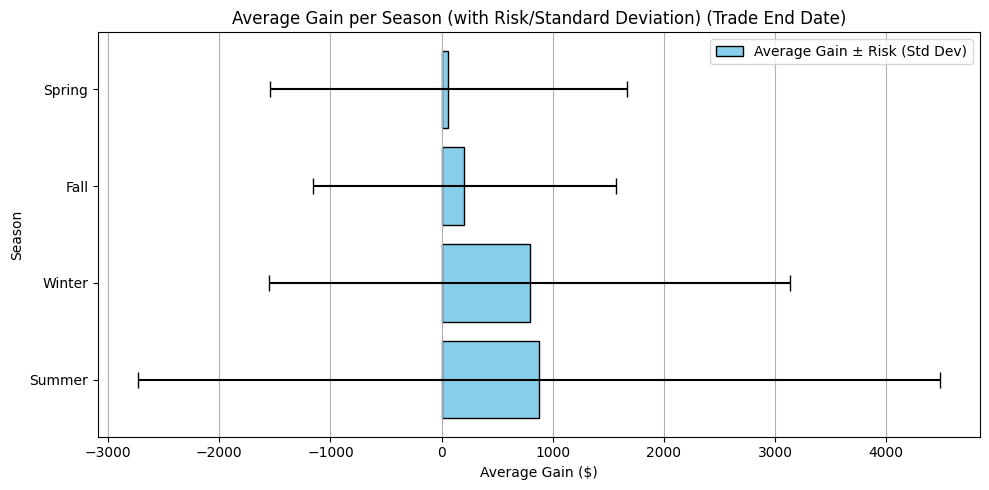

In [25]:
# Looking at Seasonal data to see if it affects trades
# df_cleaned['Trade_Date'] = pd.to_datetime(df_cleaned['Date.1'], errors='coerce') # this was code from earlier, put here to help remember what I am referencing

def assign_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_cleaned['Season'] = df_cleaned['Trade_Date'].apply(assign_season)
season1_stats = df_cleaned.groupby('Season')['Gain $'].agg(['mean', 'std'])
season1_stats_sorted = season1_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(season1_stats_sorted.index, season1_stats_sorted['mean'], xerr=season1_stats_sorted['std'], color='skyblue', edgecolor='black', capsize=6, label='Average Gain ± Risk (Std Dev)')

plt.title('Average Gain per Season (with Risk/Standard Deviation) (Trade End Date)')
plt.xlabel('Average Gain ($)')
plt.ylabel('Season')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.show()


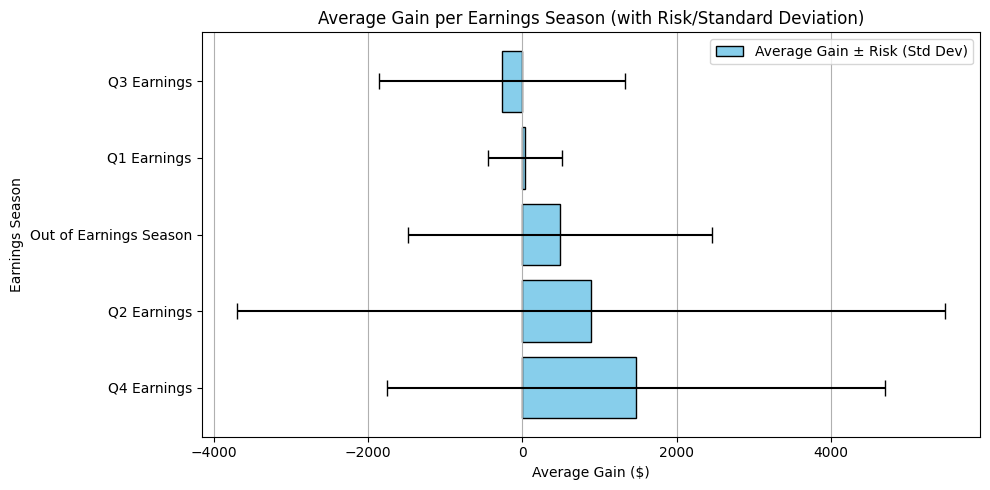

In [23]:
# Looking at Earnings Season's data to see if it affects trades

def assign_earnings(date):
    month = date.month
    day = date.day
    if (month == 1 and day >= 15) or (month == 2 and day <= 15):
        return 'Q4 Earnings'
    elif (month == 4 and day >= 15) or (month == 5 and day <= 15):
        return 'Q1 Earnings'
    elif (month == 7 and day >= 15) or (month == 8 and day <= 15):
        return 'Q2 Earnings'
    elif (month == 10 and day >= 15) or (month == 11 and day <= 15):
        return 'Q3 Earnings'
    else:
        return 'Out of Earnings Season'

df_cleaned['Earnings_Season'] = df_cleaned['Trade_Date'].apply(assign_earnings)
earnings_season1_stats = df_cleaned.groupby('Earnings_Season')['Gain $'].agg(['mean', 'std'])
earnings_season1_stats_sorted = earnings_season1_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(earnings_season1_stats_sorted.index, earnings_season1_stats_sorted['mean'], xerr=earnings_season1_stats_sorted['std'], color='skyblue', edgecolor='black', capsize=6, label='Average Gain ± Risk (Std Dev)')

plt.title('Average Gain per Earnings Season (with Risk/Standard Deviation) (Trade End Date)')
plt.xlabel('Average Gain ($)')
plt.ylabel('Earnings Season')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.show()


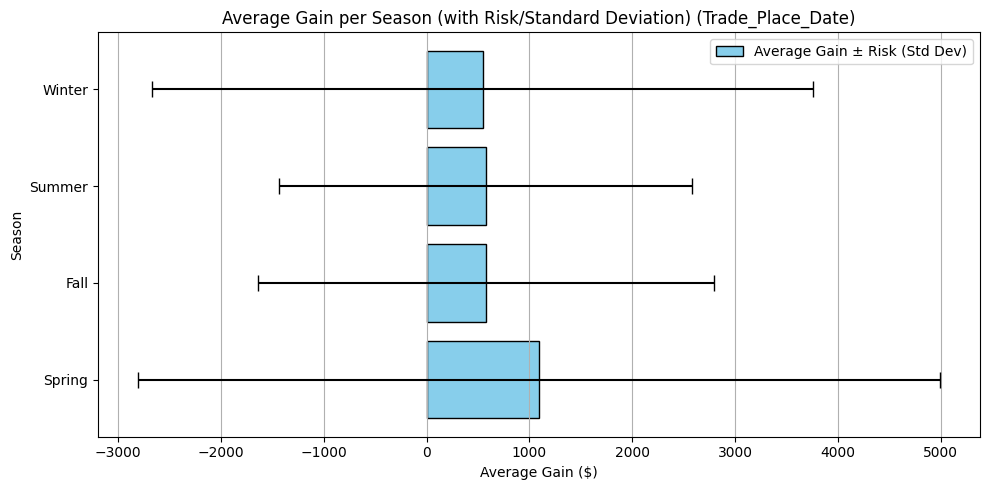

In [28]:
# Seeing what matters more, when the trade was initially bought or when it was sold
# Date is when it would bought, Date.1 is when it was sold

df_cleaned['Trade_Start_Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')

df_cleaned['Season (Start Date)'] = df_cleaned['Trade_Start_Date'].apply(assign_season)
season_stats = df_cleaned.groupby('Season (Start Date)')['Gain $'].agg(['mean', 'std'])
season_stats_sorted = season_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(season_stats_sorted.index, season_stats_sorted['mean'], xerr=season_stats_sorted['std'], color='skyblue', edgecolor='black', capsize=6, label='Average Gain ± Risk (Std Dev)')

plt.title('Average Gain per Season (with Risk/Standard Deviation) (Trade_Place_Date)')
plt.xlabel('Average Gain ($)')
plt.ylabel('Season')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.show()


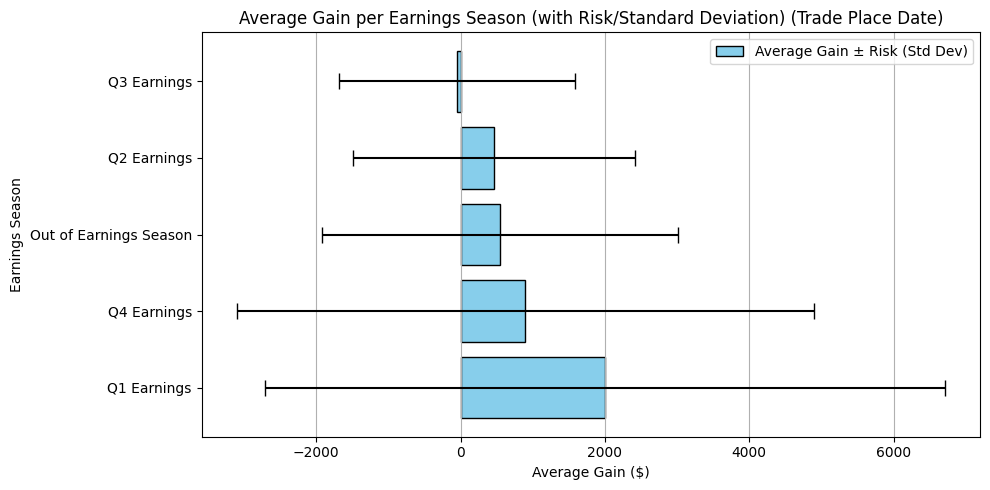

In [29]:
df_cleaned['Earnings_Season_Start'] = df_cleaned['Trade_Start_Date'].apply(assign_earnings)
earnings_season_stats = df_cleaned.groupby('Earnings_Season_Start')['Gain $'].agg(['mean', 'std'])
earnings_season_stats_sorted = earnings_season_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(earnings_season_stats_sorted.index, earnings_season_stats_sorted['mean'], xerr=earnings_season_stats_sorted['std'], color='skyblue', edgecolor='black', capsize=6, label='Average Gain ± Risk (Std Dev)')

plt.title('Average Gain per Earnings Season (with Risk/Standard Deviation) (Trade Place Date)')
plt.xlabel('Average Gain ($)')
plt.ylabel('Earnings Season')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.show()


R² score: -0.05302962539245337
MSE: 5174075.544529094


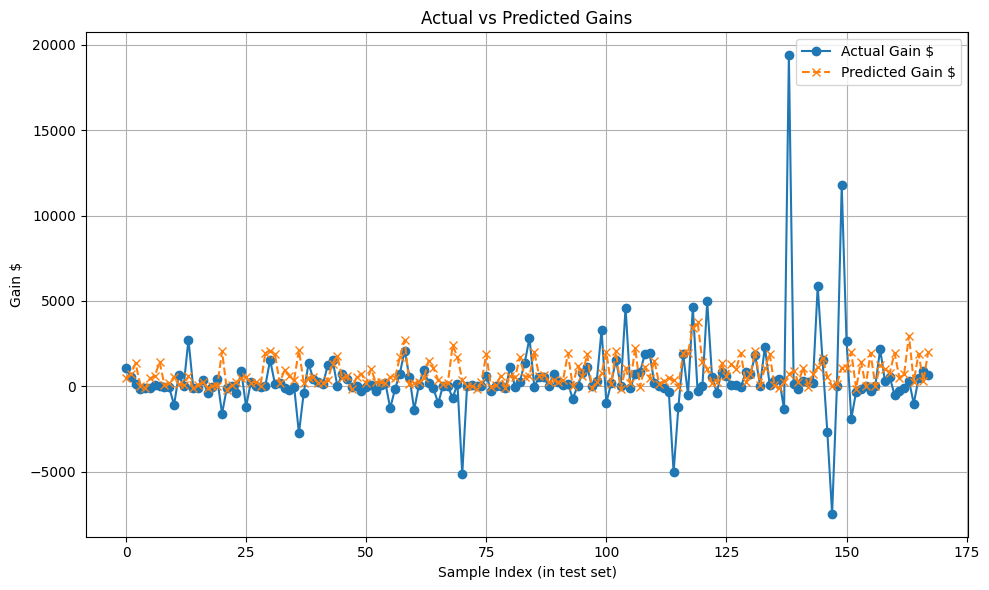

In [18]:
# Many outliers make predicting returns hard, though is still fun. Also, lack of features in the data plays a large role in making worse predictions. 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Ensure data is clean
df_ml = df_cleaned[['Symbol', 'Symbol_Filled', 'Total Cost $', 'Gain $']].copy()
df_ml = df_ml.dropna()

# Convert Total Cost $ and Gain $ to numeric
df_ml['Total Cost $'] = pd.to_numeric(df_ml['Total Cost $'], errors='coerce')
df_ml['Gain $'] = pd.to_numeric(df_ml['Gain $'], errors='coerce')
df_ml = df_ml.dropna()

# Create trade frequency feature (how many times each symbol_filled is traded)
trade_freq = df_ml['Symbol_Filled'].value_counts().to_dict()
df_ml['Trade_Frequency'] = df_ml['Symbol_Filled'].map(trade_freq)

# Encode Symbol (transaction type: Sell, Buy To Close, etc.) using one-hot encoding
encoded = pd.get_dummies(df_ml['Symbol'], prefix='Symbol')

# Final feature matrix
X = pd.concat([encoded, df_ml[['Trade_Frequency', 'Total Cost $']]], axis=1)
y = df_ml['Gain $']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

print("R² score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

y_test = y_test.reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Gain $', linestyle='-', marker='o')
plt.plot(y_pred_series, label='Predicted Gain $', linestyle='--', marker='x')

plt.title('Actual vs Predicted Gains')
plt.xlabel('Sample Index (in test set)')
plt.ylabel('Gain $')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
